## MobileNet
- Mobile net is a model which gives reasonably good imagenet classification accuracy and occupies very less space. (17 MB according to keras docs).

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob 
import matplotlib.pyplot as plt
import csv

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import clear_output

Using TensorFlow backend.


## Processing the data
Now it's time to import the data. What I want to do is:

1. Load and display some positive and negative test examples
2. Split the train data into train and dev sets

In [2]:
path = "input/subset_data/" 
labels = pd.read_csv(path + 'train_labels_full.csv')
train_path = path + 'train/'
test_path = path + 'test_with_outputs/'

## Create a dataframe which contains every training examples path, id and label:

In [3]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: ((x.split("n")[2].split('.')[0])[1:]))
df = df.merge(labels, on = "id")
df.head(3)

,path,id,label
0,input/subset_data/train/cc3f88c975016c14a6d88c...,cc3f88c975016c14a6d88cdd1c575050a4c22101,1
1,input/subset_data/train/2c883bf56b24dfc8a4e45d...,2c883bf56b24dfc8a4e45d318bf106a5ce642afb,0
2,input/subset_data/train/d817ec52de2d5930362bd9...,d817ec52de2d5930362bd994b3dcd5fb73081877,1


## Choose 4 random positve and negative examples, find their respective path then display them in a subplot:

In [4]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

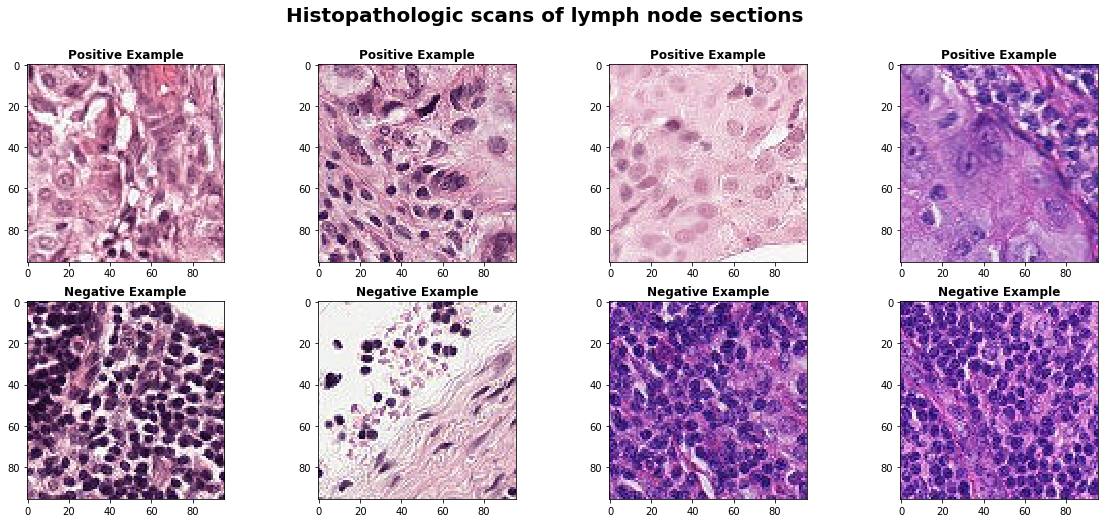

In [5]:
positive_indices = list(np.where(df["label"] == True)[0])
negative_indices = list(np.where(df["label"] == False)[0])
rand_pos_inds = random.sample(positive_indices, 4)
rand_neg_inds = random.sample(negative_indices, 4)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, fontweight='bold')

for i in range(0, 4):
    ax[0,i].imshow(readImage(df.iloc[rand_pos_inds[i],0]))
    ax[0,i].set_title("Positive Example", fontweight='bold')
    
    ax[1,i].imshow(readImage(df.iloc[rand_neg_inds[i],0]))
    ax[1,i].set_title("Negative Example", fontweight='bold')

## Train/Validation Split and Loading the Data
Increasing the size of the image results in a much higher performance.

In [6]:
IMG_SIZE = 192
BATCH_SIZE = 128

In [7]:
test_list = os.listdir(test_path)
train_list = os.listdir(train_path)
print("There are " + str(len(train_list)) + " training examples.")
print("There are " + str(len(test_list)) + " test examples.")

There are 4000 training examples.
There are 1000 test examples.


In [8]:
df['label'] = df['label'].astype(str)
train, valid = train_test_split(df, test_size=0.2, stratify = df['label'])

## Going to split 20% of the training set into a validation set.

In [9]:
df['label'] = df['label'].astype(str)
train, valid = train_test_split(df, test_size=0.2, stratify = df['label'])

In [10]:
"This is not effective!"
def crop_centre(image, crop_length):
    original_size = image.shape[0]
    centre = original_size // 2
    lower_bound = centre - crop_length // 2 
    upper_bound = centre + crop_length // 2
    image = image[(lower_bound):(upper_bound),(lower_bound):(upper_bound)]
    return image

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  vertical_flip = True,
                                  horizontal_flip = True,
                                  rotation_range=90,
                                  zoom_range=0.2, 
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.05,
                                  channel_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale = 1./255) 

In [12]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (IMG_SIZE,IMG_SIZE),
                                                    class_mode = "binary",
                                                    batch_size=BATCH_SIZE,
                                                    seed = 110318,
                                                    shuffle = True)

Found 3200 images belonging to 2 classes.


In [13]:
valid_generator = test_datagen.flow_from_dataframe(dataframe = valid,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   class_mode = 'binary',
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False)

Found 800 images belonging to 2 classes.


In [14]:
from keras.applications.mobilenet import MobileNet

dropout_fc = 0.5

conv_base = MobileNet(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))

my_model = Sequential()

my_model.add(conv_base)
my_model.add(Flatten())
my_model.add(Dense(256, use_bias=False))
my_model.add(BatchNormalization())
my_model.add(Activation("relu"))
my_model.add(Dropout(dropout_fc))
my_model.add(Dense(1, activation = "sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_192 (Model)   (None, 6, 6, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               9437184   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

## Note:
As we're using MobileNet trained on ImageNet, we're going to need to train the last few layers instead of the just the last one. Cell images are quite different to what you see on ImageNet.

In [16]:
conv_base.Trainable=True

layers_list = ["conv_dw_13","conv_dw_13_bn","conv_dw_13_relu","conv_pw_13","conv_pw_13_bn","conv_pw_13_relu",]

set_trainable=False
for layer in conv_base.layers:
    if layer.name in layers_list:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
from keras import optimizers
my_model.compile(optimizers.Adam(0.001), loss = "binary_crossentropy", metrics = ["accuracy"])

In [18]:
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size

In [19]:
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [20]:
history = my_model.fit_generator(train_generator,
                                     steps_per_epoch = train_step_size,
                                     epochs = 10,
                                     validation_data = valid_generator,
                                     validation_steps = valid_step_size,
                                     callbacks = [reduce, earlystopper],
                                     verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 0.6232 - acc: 0.7759 - val_loss: 0.7877 - val_acc: 0.7917
Epoch 2/10
25/25 [==============================] - 27s 1s/step - loss: 0.4191 - acc: 0.8256 - val_loss: 0.6649 - val_acc: 0.8006
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.3691 - acc: 0.8384 - val_loss: 0.5216 - val_acc: 0.8289
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.3466 - acc: 0.8516 - val_loss: 0.4910 - val_acc: 0.8363
Epoch 5/10
25/25 [==============================] - 27s 1s/step - loss: 0.3406 - acc: 0.8569 - val_loss: 0.3903 - val_acc: 0.8423
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.3203 - acc: 0.8753 - val_loss: 0.3558 - val_acc: 0.8705
Epoch 7/10
25/25 [==============================] - 28s 1s/step - loss: 0.3199 - acc: 0.8612 - val_loss: 0.4279 - val_acc: 0.8378

Epoch 00007: ReduceLROnPlateau reducing l

## Analysis
Now that our model has been trained, it is time to plot some training graphs to see how our accuracies and losses varied over epochs.

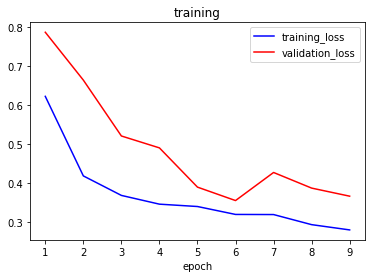

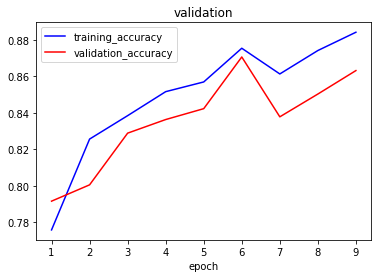

In [21]:
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig("training.png", bbox_inches='tight')
plt.show()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig("validation.png", bbox_inches='tight')
plt.show()

Found 800 images belonging to 2 classes.


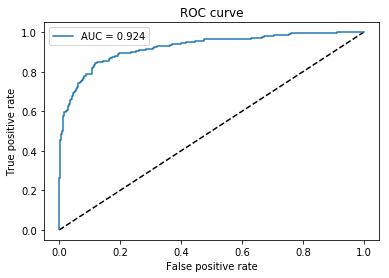

In [22]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(valid,
                                                                                  x_col = 'path',
                                                                                  y_col = 'label',
                                                                                  target_size = (IMG_SIZE,IMG_SIZE),
                                                                                  class_mode = 'binary',
                                                                                  batch_size = BATCH_SIZE,
                                                                                  shuffle = False)
predictions = my_model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=2)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC_PLOT.png', bbox_inches='tight')
plt.show()

## Predictions
- For predictions we are going to use Test Time Augmentation. For each test image we will augment it 5 ways and average the prediction. We've also used ensemble learning by averaging the results of 3 versions of this model, it improves result.
- We will be using our test data to find out the test accuracy.

In [23]:
testdf = pd.DataFrame({'path': glob(os.path.join(test_path, '*.tif'))})
testdf['id'] = testdf.path.map(lambda x: (x.split("/")[3].split('.')[0]))
testdf.head(3)

,path,id
0,input/subset_data/test_with_outputs/06ee549b7c...,06ee549b7c9cb3e81d3e26d5eb09d5a72701d6d2
1,input/subset_data/test_with_outputs/333aa08b55...,333aa08b55948996065dd425b5d27e6dbd56b411
2,input/subset_data/test_with_outputs/28f74e4f69...,28f74e4f690f2538ba85a6489adbae5eadad622b


In [24]:
tta_datagen = ImageDataGenerator(rescale=1./255, #Normalise
                                 vertical_flip = True,
                                 horizontal_flip = True,
                                 rotation_range=90,
                                 zoom_range=0.2, 
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.05,
                                 channel_shift_range=0.1)

In [25]:
tta_steps = 5
predictions_dataframe = pd.DataFrame()
for index in range(0, len(testdf)):
    data_frame = pd.DataFrame({'path': testdf.iloc[index,0]}, index=[index])
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split('.')[0])
    img_path = data_frame.iloc[0,0]
    test_img = cv2.imread(img_path)
    test_img = cv2.resize(test_img,(IMG_SIZE,IMG_SIZE))
    test_img = np.expand_dims(test_img, axis = 0)  
    predictionsTTA = []
    for i in range(0, tta_steps):
        preds = my_model.predict_generator(tta_datagen.flow_from_dataframe(dataframe = data_frame,
                                                                           directory = None,
                                                                           x_col = 'path',
                                                                           target_size = (IMG_SIZE, IMG_SIZE),
                                                                           class_mode = None,
                                                                           batch_size = 1,
                                                                           shuffle = False), steps = 1)
        predictionsTTA.append(preds)
    clear_output()
    prediction_entry = np.array(np.mean(predictionsTTA, axis=0))
    data_frame['label'] = prediction_entry
    predictions_dataframe = pd.concat([predictions_dataframe, data_frame[['id', 'label']]])

In [26]:
predictions_dataframe.set_index('id')
predictions_dataframe.head(10)

,id,label
0,06ee549b7c9cb3e81d3e26d5eb09d5a72701d6d2,0.007250
1,333aa08b55948996065dd425b5d27e6dbd56b411,0.999797
2,28f74e4f690f2538ba85a6489adbae5eadad622b,0.171806
3,db129087ad115ba788adc67fe1ed16c48cc22c8f,0.995352
4,3bfbcdafc997c1d2b1b361b03780d6f53a5aa8d8,0.476158
5,306fcdf898522c4ef3743630b1e50a21d749a843,0.003185
6,a5b7d32fd0fbc256c3604e1f967cf93197929cf7,0.022206
7,d45046fb217855c38c23919cbf6fba135570b508,0.118827
8,cda6d8df8816424f796a9796d67bdcf4f4696c19,0.124958
9,8a172811e9ee3111e4bb864543ae8ea7ba8e65bf,0.999987


In [27]:
''' A classical mathematical rounding by Voznica '''
def round_half_up(x,y=0): 
    m = int('1'+'0'*y) # multiplier - how many positions to the right
    q = x*m # shift to the right by multiplier
    c = int(q) # new number
    i = int( (q-c)*10 ) # indicator number on the right
    if i >= 5:
        c += 1
    return c/m
''' Just ignore above '''

'''A simple manual way to check prediction accuracy on test data set'''
predictions = dict()
truth = dict()

# add id: label to predictions
for index, row in predictions_dataframe.iterrows():
    image_id = row['id']
    image_label = row['label']
    predictions[image_id] = round_half_up(image_label)
    
# add id: label to truth 
with open('input/subset_data/train_labels_full.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    next(readCSV, None)
    for row in readCSV:
        image_id_csv = row[0]
        image_label_csv = row[1]
        if image_id_csv in predictions.keys():
            truth[image_id_csv] = image_label_csv

In [28]:
number_of_correct_predictions = 0

for image_id in predictions.keys():
    if int(predictions[image_id]) == int(truth[image_id]):
        number_of_correct_predictions += 1

accuracy = number_of_correct_predictions/len(predictions)       
print("accuracy on test data set: ", accuracy)

accuracy on test data set:  0.883
